In [1]:
from geotiff import GeoTiff
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
pairs = pd.read_csv('data/pairs/pairs.csv')

In [3]:
lat, lon = pairs.loc[:, 'lat'].to_numpy().astype(int), pairs.loc[:, 'lon'].to_numpy().astype(int)

In [4]:
def decode_tif(lat, lon, tifname):

    lon1 = lon.min()
    lon2 = lon.max()
    lat1 = lat.min()
    lat2 = lat.max()
    arr = np.array(GeoTiff(tifname).read_box([(lon1, lat1), (lon2, lat2)]))
    ilon = np.round((lon-lon1)/(lon2-lon1)*(arr.shape[1]-1)).round().astype(np.int64)
    ilat = np.round((lat2-lat)/(lat2-lat1)*(arr.shape[0]-1)).round().astype(np.int64)
    out = np.array([arr[ilat[i], ilon[i]] for i in range(ilon.shape[0])])

    return out


In [5]:
tifname = 'data/agro/soil/so2015v2.tif'
pairs.loc[:, 'soiltype'] = decode_tif(lat, lon, tifname)
tifname = 'data/agro/cover/GLOBCOVER_L4_200901_200912_V2.3.tif'
pairs.loc[:, 'covertype'] = decode_tif(lat, lon, tifname)


In [6]:
cover_df = pd.read_excel('/Users/haru4me/Documents/NeuralODE_v2/data/agro/cover/Globcover2009_Legend.xls', usecols=['Value', 'Label'])
soil_df = pd.read_csv('data/agro/soil/2015_suborders_and_gridcode.txt', sep='\t')

In [7]:
soils = pairs.merge(cover_df, left_on='covertype', right_on='Value')\
               .merge(soil_df, left_on='soiltype', right_on='GRIDCODE')\
               .drop(['Value', 'GRIDCODE', 'lat', 'lon', 's_ind', 'dist', 's_lat', 's_lon'], axis=1)\
               .rename(columns={'Label': 'cover_name', 'SOIL_ORDER': 'soil_label', 'SUBORDER': 'suborder'})\
               .astype({'covertype':'int64'})

soils.loc[:, 'covertype'] = soils.covertype.map(
    {elm: i for i, elm in enumerate(soils.covertype.sort_values().unique())}).astype(int)

soils.loc[:, 'soiltype'] = soils.soiltype.map(
    {elm: i for i, elm in enumerate(soils.soiltype.sort_values().unique())}).astype(int)

soils_label = pd.DataFrame()
soils_label.loc[:, 'soiltypes'] = {i: elm for i, elm in  enumerate(soils.soil_label.unique())}.keys()
soils_label.loc[:, 'soil_label'] = {i: elm for i, elm in  enumerate(soils.soil_label.unique())}.values()

soils = soils.merge(soils_label, on='soil_label')\
                .drop('soiltype', axis=1)\
                .rename(columns={'soiltypes': 'soiltype'})

In [8]:
soils.to_parquet('data/soil_info.parquet')

In [9]:
agro = pd.read_parquet('data/agro.parquet').sort_values(by=['ind', 'datetime'])
syn = pd.read_parquet('data/new_syn.parquet').sort_values(by=['ind', 'datetime'])

df = syn.merge(agro, on=['ind', 'datetime']).merge(soils, on='ind').dropna()
pairs = df[['ind', 'datetime']].drop_duplicates()
filter = [(i, t0) for i, t0, t1 in zip(pairs.ind, pairs.datetime[:-1], pairs.datetime[1:]) if 10 <= (t1-t0).days <= 11]
pairs = df.groupby(['ind', 'datetime']).count().loc[filter]
pairs = pairs[pairs.t2m == 80].reset_index()[['ind', 'datetime']]

pairs = [(i, t0, t1) for i, t0, t1 in zip(pairs.ind, pairs.datetime[:-1], pairs.datetime[1:]) if 10 <= (t1-t0).days <= 11]

df.set_index(['ind', 'datetime'], inplace=True)

In [10]:
pbar = tqdm(total=len(pairs))
with pbar:
    for i, t1, t2 in pairs:
        data = pd.concat((df.loc[i, t1], df.loc[i, t2].iloc[[0]]), axis=0)
        features = data[['t2m', 'td2m', 'ff', 'R12', 'phi',
                         'air', 'soilw', 'precip', 'soiltype', 'covertype']].to_numpy()[:80]
        targets = data[['val_1', 'val_2']].to_numpy()[[0, -1]]
        np.savez_compressed(f"data/dataset/{i}_{t1.date().strftime('%Y-%m-%d')}_{t2.date().strftime('%Y-%m-%d')}",
                            feature=features, target=targets, ind=i, t1=t1, t2=t2)
        pbar.update(1)


100%|██████████| 43146/43146 [1:36:37<00:00,  7.44it/s]


In [25]:
from src.tools.data import DataNPZ
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [26]:
from scipy.stats import ks_2samp

In [32]:
tv, tz = next(iter(DataLoader(DataNPZ('train'), batch_size=len(DataNPZ('train')))))
vv, vz = next(iter(DataLoader(DataNPZ('val'), batch_size=len(DataNPZ('val')))))


In [44]:
info = pd.read_parquet('data/soil_info.parquet')

In [46]:
from pathlib import Path
from collections import Counter

In [52]:
soilcnt = Counter() 

for i in info.soiltype.unique():
    ind = info[info.soiltype == i].ind.unique()
    for j in ind:
        soilcnt[f'{i}'] += len(list(Path('data/dataset').rglob(f'{j}*.npz')))

In [53]:
covercnt = Counter()

for i in info.covertype.unique():
    ind = info[info.covertype == i].ind.unique()
    for j in ind:
        covercnt[f'{i}'] += len(list(Path('data/dataset').rglob(f'{j}*.npz')))

In [54]:
soilcnt = pd.Series(dict(soilcnt))
covercnt = pd.Series(dict(covercnt))

In [55]:
import seaborn as sns

In [56]:
plt.style.use('classic')
plt.rc('font', family='Times New Roman')

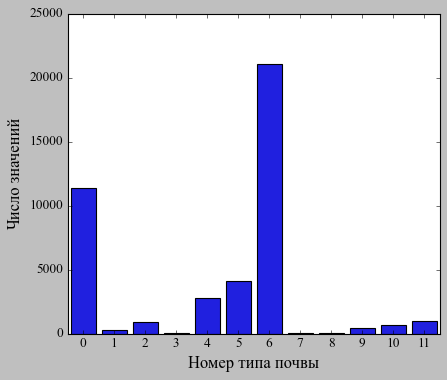

In [91]:
plt.figure(figsize=(6,5))
sns.barplot(x=soilcnt.index, y=soilcnt, color='b')
plt.ylabel("Число значений", size=15)
plt.xlabel("Номер типа почвы", size=15)
plt.savefig(f'assets/soil.png', bbox_inches='tight', dpi=160)
plt.show()


In [89]:
covercnt.index = covercnt.index.astype(int)

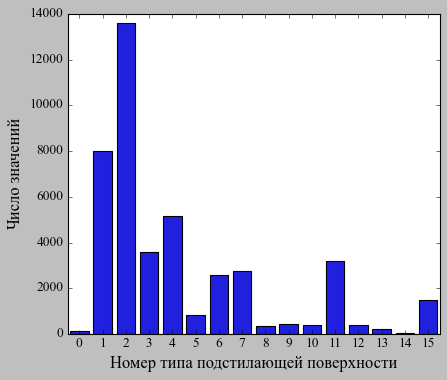

In [92]:
plt.figure(figsize=(6, 5))
sns.barplot(x=covercnt.sort_index().index,
             y=covercnt.sort_index().values, color='b')
plt.ylabel("Число значений", size=15)
plt.xlabel("Номер типа подстилающей поверхности", size=15)
plt.savefig(f'assets/cover.png', bbox_inches='tight', dpi=160)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


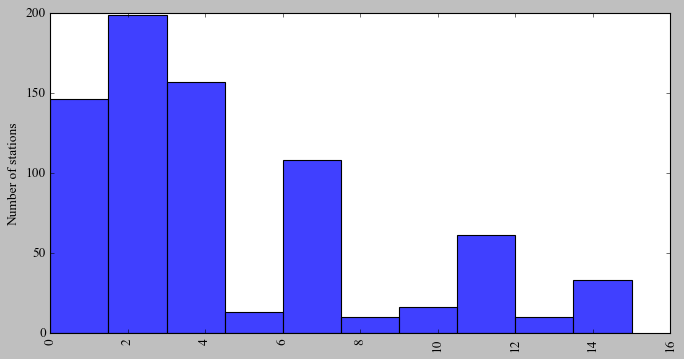

In [60]:
plt.figure(figsize=(10, 5))
sns.histplot(x=info.covertype.value_counts().sort_values().index,
             weights=info.covertype.value_counts().sort_values())
plt.xticks(rotation=90)
plt.ylabel("Number of stations")
plt.show()


In [12]:
import matplotlib.pyplot as plt